## 2. Train Random Forest Classifier model and save model for prediction

Author: Gayathri Nadar, SCF MPI-CBG </br>
Date: 2021-10-19 </br>
For: Rudrarup </br>
Lab: Tang </br> 

### About 
- This notebook is a part of 3 notebooks in sequence:
    * 1_read_images
    * 2_train_save_classifier 
    * 3_do_prediction 
- This notebook **reads the training images and labels saved as npy arrays from the previous step and trains a classifier model.**
- **The trained classifier model is saved** for predictions on future datasets. 

### Preparations
Python:

- **Keep this jupyter notebook and `functions.py` together!**
- Set up python and jupyter, and conda env. Check document 'Readme_Python_installation'.
- **When you open this notebook. Click on Kernel > Change kernal and change it to 'imageclassification'**

### General Jupyter Notebook Usage: The basics
- The notebook is executed cell-by-cell.
- The active/current cell is visible by being surrounded by a blue or green box.
- Green box: edit mode. Blue box: view mode. To exit the edit mode: press Esc
- To run a cell: Press Shift+Enter (runs the cell and automatically advances to the next cell)
- Auto-complete is supported (convenient when you e.g. type a folder location): start typing, then press Tab key.
- When you are completely finished: Click on Kernel->Shutdown and close all notebooks related tabs.
- **If you want to do a fresh start of the analysis: click on Kernel -> Restart and Clear Output**. Do this if your notebook seems to have hung. 

### Usage of this notebook:
- Start at the top.
- Run cells step-by-step.
- For cells titled **\"User Input\"**. Adjust the content (data folder etc.) before running them.
- Note: if you accidentally ran it already, simply click on it, adjust the content, and run it again.

### Current workflow 
User Input:

- Path to folder `training_data` saved in the previous step. 

Steps:

- The npy arrays are read from the folder. 
- From each image in the training set, a feature vector is extracted.
- All the feature vectors are concatenated into a numpy array.
- The training data (feature vector + label) is split into training and evaluation data. (ratio = 90:10)
- A random forest classifier is trained and evaluated. 
- The trained model is saved.


### Output 
Found in the folder `classifierfile`
- 1 classifier file (.pkl)

### Prep: Always run this cell

In [2]:
import numpy as np 
import os
from os.path import join 
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score

from functions import * 

np.random.seed(0)

### User Input 

1. Enter the path to the folder `training_data` created in the previous step.

In [3]:
path_to_training_data = "../data/training_data/"
classifier_name = "classifier_final"

### Find training data: images and labels

In [4]:
train_images_path = [join(path_to_training_data, f) for f in os.listdir(path_to_training_data) if "_images" in f][0]
train_labels_path = [join(path_to_training_data, f) for f in os.listdir(path_to_training_data) if "_labels" in f][0]

print("Found training images: ", train_images_path)
print("Found training labels: ", train_labels_path)

Found training images:  ../data/training_data/training_images.npy
Found training labels:  ../data/training_data/training_labels.npy


### Load the training data from numpy arrays 

- print some metadata

In [5]:
images_array = np.load(train_images_path)
labels_array = np.load(train_labels_path)

print("Loaded training data successfully.")
print("Shape of training image data =", images_array.shape)
print("Shape of training labels data =", labels_array.shape)
print("Total no of training samples =", images_array.shape[0])
print("No of samples from each class = (No samples/3) =", int(images_array.shape[0]/3))

Loaded training data successfully.
Shape of training image data = (450, 512, 512)
Shape of training labels data = (450,)
Total no of training samples = 450
No of samples from each class = (No samples/3) = 150


### Display some randomly chosen images 

Run the cell below multiple times to view differently chosen image.

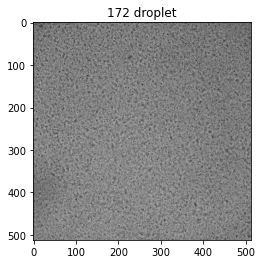

In [6]:
idx = np.random.randint(0, len(images_array))
plt.imshow(images_array[idx, :, :], cmap= 'gray')
plt.title(str(idx) + " " + labels_array[idx])
plt.show()

### Extract features from each image in the training set 

In [7]:
if os.path.exists(join(path_to_training_data, "training_features.npy")):
    print("Features already extracted. Loading features from saved file.")
    x_features = np.load(join(path_to_training_data, "training_features.npy"))

else:
    x_features = []

    for i in range(images_array.shape[0]):
        print("Computing features for image ({} / {})".format(i + 1, images_array.shape[0]))
        img = images_array[i,...]
    #     fv_multiscale = getMultiscaleFeature(img, sigma_min= 1, sigma_max= 16)
    #     x_features.append(fv_multiscale.flatten())

        fv_hu_moments = getMomentsFeature(img)
        fv_haralick   = getHaralickFeature(img)
        fv_histogram  = getHistogramFeature(img)

        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
        x_features.append(global_feature)

    print("Feature extraction done!")
    x_features = np.asarray(x_features)
    np.save(join(path_to_training_data, "training_features"), x_features)

Features already extracted. Loading features from saved file.


### Get the labels for the training data

In [8]:
x_labels = labels_array

print("Feature array shape (N samples, features) = ", x_features.shape)
print("Labels array shape (N samples, ) = ", x_labels.shape)

Feature array shape (N samples, features) =  (450, 276)
Labels array shape (N samples, ) =  (450,)


### Training model: Run just once!

In [9]:
print("Starting model training...this might take time!")

# split data into training and evaluation set
x_train_feature, x_test_feature, y_train_feature, y_test_feature = train_test_split(x_features, x_labels, 
                                                                                    test_size=0.2, random_state=0)

# train model with randomforestclassifer
clf_feature = RandomForestClassifier().fit(x_train_feature, y_train_feature)

print("Model training done.")

print("Evaluating trained model...")
# evaluate the model with test data
y_pred_feature = clf_feature.predict(x_test_feature)

print("Evaluation done.")

Starting model training...this might take time!
Model training done.
Evaluating trained model...
Evaluation done.


### Print some metrics from the trained model

In [10]:
print("Precision score = ", 100 * precision_score(y_test_feature, y_pred_feature, average='weighted'), "%")
print("Accuracy score = ", 100 * accuracy_score(y_test_feature, y_pred_feature), "%") 
print("F1 score =", 100 * f1_score(y_test_feature, y_pred_feature, average='weighted', labels=np.unique(y_pred_feature)), "%")

Precision score =  95.62707535121329 %
Accuracy score =  95.55555555555556 %
F1 score = 95.5197956577267 %


### Save classifier

In [11]:
# save classifier
savedir = os.path.join(os.path.dirname(os.path.dirname(path_to_training_data)), "classifierfile") 
if not os.path.exists(savedir):
    os.makedirs(savedir)

    
print("Saving classifier to folder: ", savedir)
    
with open(os.path.join(savedir, classifier_name + '.pkl'), 'wb') as fid:
    pickle.dump(clf_feature, fid)  
    
    
print("DONE")

Saving classifier to folder:  ../data/classifierfile
DONE
